In [51]:
# Jupyter Notebook conveniences
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
# Importing these just to annotate the code better
import pathlib
import fastai

# We use IPython to clear the cell output
import IPython
 
# Fast AI is an amazing library built on PyTorch.  We grab the stuff we need to make a WGAN
from fastai.vision import *
from fastai.vision.gan import *

In [56]:
## Some basic utility functions
PATH = '/your/folder/path'

# Print out the contents of a PosixPath directory
def ls(path:pathlib.PosixPath):
    for item in path.iterdir(): print(item)
        
# Generate a set of sample images from our using a helpful GANLearner method
def generate_sample(learner:fastai.vision.gan.GANLearner):
    learner.gan_trainer.switch(gen_mode=True)
    learner.show_results(ds_type=DatasetType.Train, rows=2, figsize=(8,8))
    learner.gan_trainer.switch(gen_mode=False)
    
## Pass values to our model and generate an image (uses the global learn because I was lazy)
def generate_image(*xs):
    # Grab the generated image
    generated_tensor = learn.gan_trainer.generator(*xs)
    
    # Get the denormalized RGB values for the output (channel x width x height)
    image = learn.data.denorm(generated_tensor, do_x=True)[0]
    
    # Transpose our dimensions to height x width x channel
    image = np.stack(image)
    image = np.transpose(image, [2, 1, 0])
    image = np.transpose(image, [1, 0, 2])
    
    # Return an image that plt can open
    return image
    
## Clear the cell output     
def clear_output():
    IPython.display.clear_output()

# Preparing The Data

The goal here is to evaluate our data to make sure it looks correct, and then construct a Fast.ai DataBunch to feed to our learner.

In [57]:
# Grab the PosixPath to peep at
path = pathlib.Path(PATH)

# Look at the contents of our folder, which just has our faces
ls(path)

/home/paperspace/.fastai/data/wgan-example/faces
/home/paperspace/.fastai/data/wgan-example/test.png


In [58]:
# Set the faces path so we can inspect the data
faces_path = pathlib.Path(path / 'faces')

In [60]:
# Grab the contents of the faces
faces = list(faces_path.iterdir())

# Check how many images we have (probably a better way to do this)
len(faces)

42

In [61]:
# Create a data bunch sized to our parameters
def get_data(batch_size, image_size):
    # Grab a gan item list
    return (
        GANItemList
            # Grab the target data from a folder, setting the input as random noise a 200-length vector
            .from_folder(faces_path, noise_sz=200)
            # We have no validation set, because we aren't training the generator from our images
            .no_split()
            # We aren't classifying anything
            .label_from_func(noop)
            # Set up our transforms (I think this is allowing 10 percent padding on both sides?)
            .transform(
                # Set our transforms
                tfms=[
                    # Allow image padding by 1percent to square image?
                    [crop_pad(size=image_size, row_pct=(0,1), col_pct=(0,1))], 
                    []
                ], 
                # Set the image size we converting the images to
                size=image_size, 
                # Not super clear on this
                tfm_y=True
            )
            # Create our databunch by our batch size
            .databunch(bs=batch_size)
            # We normalize to a mean and std of 0.5 for all channels, but only normalize y
            .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

In [62]:
# I'll set the batch to just use all the faces, since we have so few
batch_size = 16

# I am converting the images to 64x64 for ease of training
image_size = 64

In [63]:
# Grab some data
data_bunch = get_data(batch_size, image_size)

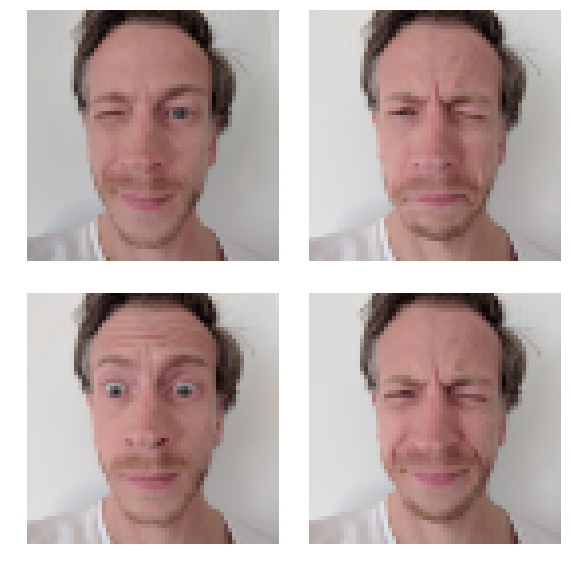

In [64]:
# Peep at some of our data
data_bunch.show_batch(rows=2, figsize=(8,8))

# Building The Generator

In [65]:
# This basic generator is adapted from fastai.vision.gan.basic_generator 
# (https://docs.fast.ai/vision.gan.html#basic_generator) 
def create_generator(input_size:int, input_channels:int, noise_size:int, feature_size:int=64):
    # Our network will use a series of convolution layers which half the number of features at each step
    # We halve to have an even number, since we will be doubling and halving the total feature count
    current_features = feature_size // 2

    # To size our initial feature layer, we double the size until we exceed our input size
    current_size = 4
    while current_size < input_size:  
        # Double current size
        current_size *= 2 
        # Double the features
        current_features *= 2
        
    # Our kernel size and stride for the initial conv layer is higher than normal, since
    # we want this initial layer to extract a lot of detail from the input
    kernel_size, stride = 4, 1
    
    # Use a leaky ReLU in cour conv_layer blocks, since it seems to work better
    # https://arxiv.org/pdf/1505.00853.pdf
    leaky=0.2

    # Create an array of layers to convert into a PyTorch model
    layers = [
        # Our initial conv_layer block is from our noise to our calculated feature size
        # We pass transpose, because we want the block to include a ConvTranpose2d layer
        conv_layer(noise_size, current_features, kernel_size, stride, leaky=leaky, transpose=True)
    ]

    # Reset current size
    current_size = 4
    
    # For the subsequent layers, we can increase our stride to capture more general features
    stride = 2
    
    # We add some padding since our stride increased, so that we can capture information on the edge
    padding = 1

    # Just like we sized our initial features, we will add new layers until we grow too large
    while current_size < input_size // 2:
        # Set our new output size
        output_size = current_features // 2
        
        # Append a new conv layer
        layers.append(
            # Create another sequence of layers of current features to it's half, kernel 4, stride 2, padding of 1
            conv_layer(current_features, output_size, kernel_size, stride, padding, leaky=leaky, transpose=True)
        )
        
        # Reduce the current features so the next conv_layer can halve again
        current_features = output_size
        
        # Increase current size (to reflect the feature reductions we have left)
        current_size *= 2
    
    # Set a longer stride for our final layers, which grab the final features 
    kernel_size, stride = 4, 2
    layers += [
        # Create our final layer to transpose to our input channels (64 x 64 x 3(RGB))
        nn.ConvTranspose2d(current_features, input_channels, kernel_size, stride=stride, padding=padding, bias=False),
        # Flatten it out
        nn.Tanh()
    ]

    # Return a model that will execute our layers in order
    return nn.Sequential(*layers)

In [66]:
# Number of channels in our image (RGB)
image_channels = 3

# Create our generator, specifying the input dimensions of the image, the number of image 
# channels (since our output will be RGB), and we are also adding one additional layer
generator = create_generator(input_size=image_size, input_channels=image_channels, noise_size=200)

# Creating The Critic

In [67]:
# Take the average of the input and flatten it into 1 dimension
def AverageFlatten():
    return Lambda(lambda x: x.mean(0).view(1))

## Like our generator, this is a simple model of convolutional layers
def create_critic(input_size:int, input_channels:int, feature_size:int=64):
    # As with our generator, our ReLU layers will be leaky to train better
    leaky = 0.2
    
    # Set sizes to do a basic Conv2D
    kernel_size, stride, padding = 4, 2, 1
    layers = [
        # Our initial layer is a basic convolution with no normalization (since the generator did that for us)
        conv_layer(input_channels, feature_size, kernel_size, stride, padding, leaky=leaky, norm_type=None)
    ]
    
    # We'll do the inverse of our generator, where each conv_layer block will ramp up the feature size
    current_size = input_size // 2
    current_features = feature_size
    
    # Add a layer for a bit of extra feature resolution
    kernel_size, stride = 3, 1
    layers.append(conv_layer(current_features, current_features, kernel_size, stride, leaky=leaky))
    
    # Check we haven't hit rock bottom and should stop adding layers
    while current_size > 4:
        # Set the new layer output features
        output_size = current_features * 2
        
        # Add an additional layer, with a slightly larger kernel and bigger stride (to capture larger feature)
        kernel_size, stride = 4, 2
        layers.append(conv_layer(current_features, output_size, kernel_size, stride, padding, leaky=leaky))
        
        # Set the values for the next layer
        current_features = output_size
        current_size //= 2
        
    # Our output size is just 1 value (real or fake)
    output_size = 1
        
    # Set the conv2D values to capture a lot of detail from the last layer
    kernel_size, stride, padding = 4, 1, 0
    layers += [
        # Add our final conv layer which outputs one value
        nn.Conv2d(current_features, output_size, kernel_size, stride, padding),
        # Calculate the mean and flatten a list of pixels for easy differencing
        AverageFlatten()
    ]
    
    # Return our network model
    return nn.Sequential(*layers)

In [68]:
# The critic, which is evaluating the generator output against real images
critic = create_critic(input_size=image_size, input_channels=image_channels)

# Start Learning

In [22]:
# Create a Wassertein Gan for reasons
learn = fastai.vision.gan.GANLearner.wgan(
    # The databunch we are loading in
    data_bunch, 
    # Our generator model
    generator, 
    # Our critic model
    critic, 
    # Whether we are evaluating a function to determine when to switch training our generator and discriminator
    switch_eval=False,
    # Since we have so few images, and short epochs, turn off the auto image generation after each epoch
    show_img=False,
    # Momentum doesn't work well with GANs, so we turn off weight decay and reduce the Adam beta
    opt_func=partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [72]:
# Loading my final weights
learn.load('wgan-example-22')

In [73]:
# Fitting once to make the generator accessible
learn.fit(1, 0.000004)

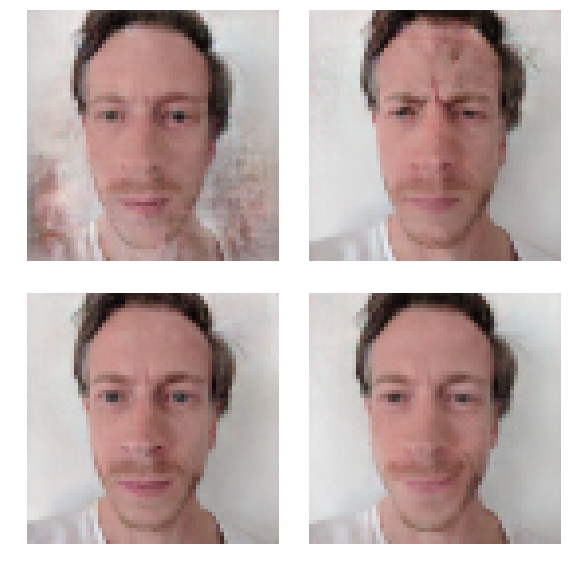

In [75]:
# Display a sample of images produced from random noise by our generator
generate_sample(learn)

In [76]:
# Generate various configurations of inputs to evaluate our model
def generate_xs(real=False, fill=False, fill_value=1., random=False):
    # If we want a real image
    if real:
        # Generate a batch of noise
        batch_iterator = iter(data_bunch.train_dl)
        *xs, _ = next(batch_iterator)
        
        return xs
    # If we want to fill all 200 dimensions with 1 values        
    if fill:
        # Return a float tensor of our values
        xs = torch.FloatTensor(torch.zeros(1, 1, 200, 1, 1)).cuda()
        xs.new_full((1, 1, 200, 1, 1), fill_value)
        
        return xs
    
    # If we want truly random values (not a distribution)
    if random:
        # RMake a tensor with random values
        xs = torch.randn(1, 1, 200, 1, 1).cuda()
        
        return xs

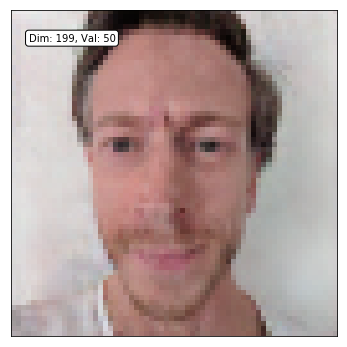

Done


In [50]:
# Create test values (and a reverse variant)
TEST_VALUES = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
TEST_VALUES_R = list(TEST_VALUES)
TEST_VALUES_R.reverse()

# Flags to determine how we are traversing through the model
reverse_index = False
reverse_values = False
restore = False

# Generate a tensor of data to mess with
xs = generate_xs(real=True)

# The text coordinates
text_x, text_y = 3, 5

# Iterate over our 200 dimensions
for index in range(200):
    # Set the index we will adjust 
    edit_index = 199 - index if reverse_index else index
    
    # If we are restoring the value, save its current state
    if restore: initial = (xs[0][0][edit_index][0][0]).item()
        
    # Check if we need to reverse through our values
    values = TEST_VALUES_R if reverse_values else TEST_VALUES
    
    # Iterate through our values
    for value in values:
        # Set a new value
        xs[0][0][edit_index][0][0] = value
    
        # Pass our values to the model and get an output we can visualize
        image = generate_image(*xs)

        # Clear the cell output and wait until it's finished
        IPython.display.clear_output(wait=True)

        # Show the image and 
        plt.figure(figsize=(6,6))
        figure = plt.imshow(image)
        
        # Set the figure size and remove the axis labels
        figure.axes.get_xaxis().set_visible(False)
        figure.axes.get_yaxis().set_visible(False)
        
        # Set a text string to let us know what dimension and value we are setting
        text_string = 'Dim: ' + str(edit_index) + ', Val: ' + str(value)
        
        # Create the text block
        plt.text(
            text_x, text_y, 
            text_string,
            color="black",
            size=10, 
            ha="left", 
            va="center",
            bbox=dict(
                boxstyle="round",
                ec=(0, 0, 0),
                fc=(1., 1., 1.),
            )
        )
        
        # Show the image and text
        plt.show()

    # If we are rest
    if restore: xs[0][0][edit_index][0][0] = initial 
print('Done')

In [ ]:
# My Training Schedule was all over the place, but generally looked like:
# LR      /     Epochs
# .002    /     3000
# .000465 /     10000
# .00002  /     10000

# Those epoch numbers look high, but our data set is so tiny the epochs are very short.  
# I had to babysit the learner quite a bit, and had a few instances of mode collapse,
# where I needed to load an earlier set of weights and try a different learning rate.